In [1]:
!pip install transformers torch torchaudio datasets librosa

### **Notebook overview**

In this notebook, we prepare the dataset with all relevant embedding vectors and other acoustic and prosodic features to do audio sentiment classification for our chosen dataset.

In [2]:
from datasets import load_dataset
import librosa
import io
import numpy as np
import torch

### **Dataset description**

10,000 audio samples representing 8 different emotions spoken by speakers of diverse age group. The dataset consists of audio samples spoken by both male and female speakers. The 8 emotion classes are "sad", "fear", "distress", "anger", "happy", "neutral" and "surprised". The audio format is raw bytes.

Link to dataset : [stapesai/ssi-speech-emotion-recognition-dataset](https://huggingface.co/datasets/stapesai/ssi-speech-emotion-recognition#dataset-card-for-ssi-speech-emotion-recognition---stapes-ai)

In [3]:
data = load_dataset("stapesai/ssi-speech-emotion-recognition")

README.md:   0%|          | 0.00/6.26k [00:00<?, ?B/s]

train-00000-of-00003.parquet:   0%|          | 0.00/373M [00:00<?, ?B/s]

train-00001-of-00003.parquet:   0%|          | 0.00/374M [00:00<?, ?B/s]

train-00002-of-00003.parquet:   0%|          | 0.00/374M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/223M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1999 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/163 [00:00<?, ? examples/s]

### **Data Preprocessing steps**

1. Convert raw audio bytes into numerical format in the form of tensors.
2. Extract sample rate for each audio sample.
3. Map emotion classes to numerical labels.
4. Resample audio samples into uniform sample rate of 16000 Hz.
5. Pad or trucate the audio sample to maintain a uniform duration of 3 seconds.


In [5]:
# pad or truncate

def pad_or_truncate(waveform, max_length = 48000):

  """
   This function pads or truncates the audio sample such that each audio
   sample has the uniform length of 3 seconds.
  """
  
  num_samples = waveform.shape[0]
  waveform = torch.tensor(waveform).unsqueeze(0)

  if num_samples < max_length:  # Pad shorter audio
      pad = torch.zeros((1, max_length - num_samples))
      waveform = torch.cat((waveform, pad), dim=1)
  elif num_samples > max_length:  # Truncate longer audio
      waveform = waveform[:, :max_length]

  return waveform


# formatting the dataset

def format_data(df):

  """
    This function formats the dataset.
    
    -> Converts audio samples from raw audio bytes to numerical waveforms.
    -> Extracts the sample rate of samples.
    -> Maps string sentiment labels to numerical sentiment labels.
  """
    
  df["audio_bytes"] =  df["file_path"].apply(lambda x: x["bytes"])
  df["waveform"], df["sample_rate"] = zip(*df["audio_bytes"].apply(
        lambda x: librosa.load(io.BytesIO(x), sr=None)
    ))
  label_mapping = {
        "ANG": 0, "FEA": 1, "SAD": 2, "DIS": 3,
        "SUR": 4, "HAP": 5, "CAL": 6, "NEU": 7
    }
  df["label"] = df["emotion"].apply(lambda x: label_mapping[x])
  df = df[["waveform", "sample_rate", "label"]]

  return df

# feature engineering

def feature_engineering(data):

  """
    This functions defines additional features to the dataset.

    -> "Length" depicts the length of overall length of the waveform. (Should be 48000.
    Sampled at 16000 Hz and 3 seconds long).
  """
    
  data["length"] = data["waveform"].apply(lambda x: len(x[0]))
  return data

# resampling data
def resample_data(data):

  """
    This function resamples the audio sample to 16000 Hz.
  """
    
  data["waveform"] = data.apply(
    lambda row: librosa.resample(np.array(row["waveform"]), orig_sr=row["sample_rate"], target_sr=16000),
    axis=1
  )
  data["sample_rate"] = data["sample_rate"].apply(lambda x: 16000)
  data["waveform"] = data["waveform"].apply(pad_or_truncate)

  return data

# preprocessing data

def preprocess_dataset(df, set_):

  """
  This function applies the overall preprocessing pipeline to each audio sample.
  """
    
  data = df[set_].to_pandas()
  data = format_data(data)
  data = resample_data(data)
  data = feature_engineering(data)
  return data

In [7]:
data_train = preprocess_dataset(data, "train")
data_val = preprocess_dataset(data, "validation")

### **Extracting embedding vectors**

Here, I have chosen three speech models : Hubert base, Word2vec base and Whisper base to extract the embedding vector from the last hidden state. The ideas is to build a classification model on top of these embedding vectors to classify sentiments. The embedding vectors will have an indepth understanding of speakers traits, phonetics and accent.

**Model links:**

1. Hubert base - [Link](https://huggingface.co/facebook/hubert-base-ls960)
2. Word2vec base - [Link](https://huggingface.co/facebook/wav2vec2-base)
3. Whisper base - [Link](https://huggingface.co/openai/whisper-base)

This notebook will cover sentiment classification using Hubert and Wav2vec

In [8]:
from transformers import AutoModel, AutoFeatureExtractor

hubert_model_name = "facebook/hubert-base-ls960"
hubert = AutoModel.from_pretrained(hubert_model_name)
hubert_feature_extractor = AutoFeatureExtractor.from_pretrained(hubert_model_name)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

config.json:   0%|          | 0.00/1.39k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/378M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/213 [00:00<?, ?B/s]

In [9]:
# Extracting sample feature vector for each model

hubert_features = hubert_feature_extractor(data_train["waveform"][0].squeeze(0), sampling_rate=16000, return_tensors="pt")

# Printing one sample feature vector for each model along with their shapes

print(f"Hubert feature :\n\n{hubert_features}\n\nShape : {hubert_features['input_values'].shape}")

Hubert feature :

{'input_values': tensor([[0.1294, 0.1294, 0.1469,  ..., 0.0010, 0.0010, 0.0010]])}

Shape : torch.Size([1, 48000])


In [10]:
import pandas as pd

# Merging train and validation datasets

data_train["split"] = "train"
data_val["split"] = "validation"
data = pd.concat([data_train, data_val], ignore_index=True)

In [12]:
from sklearn.model_selection import train_test_split

data, _ = train_test_split(data, test_size=0.5, stratify=data['label'], random_state=42)

In [15]:
data["hubert_features"] = data["waveform"].apply(lambda x: hubert_feature_extractor(x.squeeze(0), sampling_rate=16000, return_tensors="pt")["input_values"])

In [16]:
# Extracting embeddings from Hubert and Wav2vec base models
 
def get_embeddings(feature, model):
  global count, device
  count += 1

  feature = feature.to(device)  
  with torch.no_grad():
      outputs = model(feature)

  embeddings = outputs.last_hidden_state

  if count%500 == 0:
      print(f"Embeddings stored  : {count}/{len(data)}")

  return embeddings

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"
hubert_model = hubert.to(device)

count = 0
print("Extracting Hubert embeddings :\n\n")
data["hubert_embeddings"] = data["hubert_features"].apply(lambda x : get_embeddings(x, hubert_model))

Extracting Hubert embeddings :


Embeddings stored  : 500/5999
Embeddings stored  : 1000/5999
Embeddings stored  : 1500/5999
Embeddings stored  : 2000/5999
Embeddings stored  : 2500/5999
Embeddings stored  : 3000/5999
Embeddings stored  : 3500/5999
Embeddings stored  : 4000/5999
Embeddings stored  : 4500/5999
Embeddings stored  : 5000/5999
Embeddings stored  : 5500/5999


In [21]:
def scale_2d_vectors(X):

    """Function to scale 2d embedding vectors row by row."""

    X_scaled = []
    
    for i in X[0]:  
        mean = i.mean(dim=0, keepdim=True)
        std = i.std(dim=0, keepdim=True)
        
        std = std + 1e-8
        
        i_scaled = (i - mean) / std
        X_scaled.append(i_scaled)
    
    
    X_scaled = torch.stack(X_scaled)

    return X_scaled

In [22]:
data["scaled_hubert_embeddings"] = data["hubert_embeddings"].apply(scale_2d_vectors)

In [23]:
data["scaled_hubert_embeddings"][0].shape

torch.Size([149, 768])

In [26]:
X = torch.stack(data['scaled_hubert_embeddings'].tolist()).squeeze(1)

In [27]:
y = torch.tensor(data["label"].tolist())

In [33]:
from sklearn.model_selection import train_test_split


def train_test_splitter(X,y):

    """
    Given a set of traiable params 'X' and target values 'y', this function
    splits the input data into train and test sets.
    """

    X = X.cpu().numpy()
    y = y.numpy()
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)
    
    return X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor

In [34]:
from torch.utils.data import Dataset, DataLoader

# Preparing dataset for hubert and wav2vec embeddings and target labels

class EmbeddingsDataset(Dataset):
    def __init__(self, X, y):
        self.X = X  
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def data_loader(X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor):

    """This function loads the dataset using pytorch DataLoader."""

    train_dataset = EmbeddingsDataset(X_train_tensor, y_train_tensor)
    val_dataset = EmbeddingsDataset(X_val_tensor, y_val_tensor)

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

    return train_loader, val_loader

In [35]:
def data_loader_pipeline(X, y):
    X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_splitter(X,y)
    train_loader, val_loader = data_loader(X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor)
    return train_loader, val_loader

In [36]:
hubert_train_loader, hubert_val_loader = data_loader_pipeline(X,y)

In [37]:
input_size = 768
num_classes = len(set(y))

In [60]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionLayer(nn.Module):
    def __init__(self, input_size):
        super(AttentionLayer, self).__init__()
        self.attention_weights = nn.Parameter(torch.randn(input_size))  # learnable weights

    def forward(self, x):
        # Compute attention scores (using a dot product with the attention weights)
        attention_scores = torch.matmul(x, self.attention_weights)  # Shape: (batch_size, seq_length)

        # Apply softmax to get the normalized attention scores
        attention_weights = torch.softmax(attention_scores, dim=1)  # Normalize across the time steps
        
        # Weighted sum of inputs (attention pooling)
        weighted_sum = torch.sum(x * attention_weights.unsqueeze(-1), dim=1)  # Shape: (batch_size, input_size)

        return weighted_sum

In [65]:
class AttentionClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AttentionClassifier, self).__init__()
        self.attention = AttentionLayer(input_size)  # Apply attention pooling
        self.fc0 = nn.Linear(input_size, 512)
        self.fc1 = nn.Linear(512, 256)  # Fully connected layer 1
        self.fc2 = nn.Linear(256, num_classes)  # Output layer (num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Apply attention pooling
        x = self.attention(x)  # Shape: (batch_size, input_size)

        # Pass through fully connected layers
        x = self.relu(self.fc0(x))
        x = self.relu(self.fc1(x))  # Shape: (batch_size, 256)
        x = self.dropout(x)
        x = self.fc2(x)  # Shape: (batch_size, num_classes)

        return x

In [66]:
model = AttentionClassifier(input_size, num_classes)

In [67]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001) 

In [68]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in hubert_train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(hubert_train_loader):.4f}")

Epoch [1/50], Loss: 1.8779
Epoch [2/50], Loss: 1.3966
Epoch [3/50], Loss: 1.2406
Epoch [4/50], Loss: 1.1316
Epoch [5/50], Loss: 1.0532
Epoch [6/50], Loss: 0.9741
Epoch [7/50], Loss: 0.9264
Epoch [8/50], Loss: 0.8626
Epoch [9/50], Loss: 0.7843
Epoch [10/50], Loss: 0.7703
Epoch [11/50], Loss: 0.7483
Epoch [12/50], Loss: 0.6646
Epoch [13/50], Loss: 0.6390
Epoch [14/50], Loss: 0.5876
Epoch [15/50], Loss: 0.5815
Epoch [16/50], Loss: 0.5919
Epoch [17/50], Loss: 0.5308
Epoch [18/50], Loss: 0.5175
Epoch [19/50], Loss: 0.4949
Epoch [20/50], Loss: 0.4835
Epoch [21/50], Loss: 0.4533
Epoch [22/50], Loss: 0.4516
Epoch [23/50], Loss: 0.4153
Epoch [24/50], Loss: 0.4288
Epoch [25/50], Loss: 0.3938
Epoch [26/50], Loss: 0.3930
Epoch [27/50], Loss: 0.3881
Epoch [28/50], Loss: 0.3810
Epoch [29/50], Loss: 0.3632
Epoch [30/50], Loss: 0.3888
Epoch [31/50], Loss: 0.4063
Epoch [32/50], Loss: 0.3239
Epoch [33/50], Loss: 0.3396
Epoch [34/50], Loss: 0.2922
Epoch [35/50], Loss: 0.3303
Epoch [36/50], Loss: 0.3570
E

In [69]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

model.eval()
y_true = [] 
y_pred = []
correct, total = 0, 0

with torch.no_grad():
    for X_batch, y_batch in hubert_val_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)  # Get class with highest probability
        total += y_batch.size(0)
        y_true.extend(y_batch)
        y_pred.extend(predicted)
        correct += (predicted == y_batch).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 57.42%


In [70]:
y_pred_stacked = torch.stack(y_pred)
y_pred_numpy = y_pred_stacked.cpu().numpy()
y_test_stacked = torch.stack(y_true)
y_test_numpy = y_test_stacked.cpu().numpy()

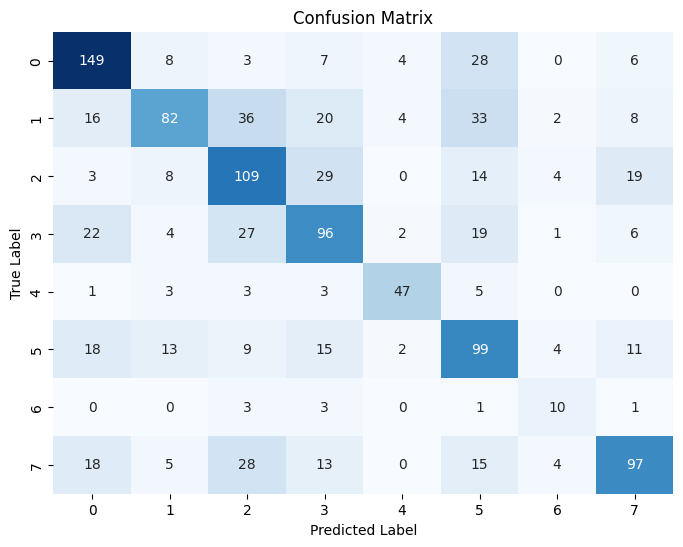

In [71]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test_numpy, y_pred_numpy)

# Step 3: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=np.unique(y_pred_numpy), yticklabels=np.unique(y_test_numpy))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [72]:
from sklearn.metrics import classification_report

report = classification_report(y_test_numpy, y_pred_numpy)
print(report)

              precision    recall  f1-score   support

           0       0.66      0.73      0.69       205
           1       0.67      0.41      0.51       201
           2       0.50      0.59      0.54       186
           3       0.52      0.54      0.53       177
           4       0.80      0.76      0.78        62
           5       0.46      0.58      0.51       171
           6       0.40      0.56      0.47        18
           7       0.66      0.54      0.59       180

    accuracy                           0.57      1200
   macro avg       0.58      0.59      0.58      1200
weighted avg       0.59      0.57      0.57      1200

